##### Load dataset

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import math
import os

In [2]:
# download
!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
!unzip ./flower_photos.zip

Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=d34bc725-9bd9-4073-8bb9-95ca013cb907
To: /content/flower_photos.zip
100% 230M/230M [00:01<00:00, 116MB/s]
Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/1043777054

In [3]:
# load data
data_patch = './flower_photos'
dataset = ImageFolder(root=data_patch)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

# split
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1
n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples
train_datset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

In [4]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# apply
train_datset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

##### DataLoader

In [5]:
BATCH_SIZE = 128

train_loader = DataLoader(
    train_datset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    valid_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE
)

#### Training from Scratch

##### Modeling

In [6]:
class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=embed_dim,
                               kernel_size=patch_size,
                               stride=patch_size,
                               bias=False)
        scale=embed_dim ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(embed_dim))
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2 + 1, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x) # shape = [*, embedding_dim, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1) # shape = [*, embedding_dim, grid ** 2]
        x = x.permute(0, 2, 1) # shape = [*, grid ** 2, embedding_dim]
        # expanding the CLS embedding
        cls_emb = self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=self.device)
        # print(self.class_embedding.to(x.dtype).shape)
        # print(cls_emb.shape)
        x = torch.cat([cls_emb, x], dim=1) # shape = [*, grid ** 2 + 1, width]

        x = x + self.positional_embedding.to(x.dtype)
        return x

In [7]:
from transformer_base.transformer_encoder import TransformerEncoderBlock

class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu', num_classes=10, patch_size=16):
        super().__init__()
        self.embed_layer = PatchPositionEmbedding(
            image_size=image_size, embed_dim=embed_dim,
            patch_size=patch_size, device=device
        )
        self.transformer_layer = TransformerEncoderBlock(
            embed_dim=embed_dim, num_heads=num_heads,
            ff_dim=ff_dim, dropout=dropout
        )
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embed_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

##### Training

In [8]:
image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size=image_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout,
    num_classes=num_classes,
    device=device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 100
save_model = '.'
model_name = 'vit_flowers'

from utils.train import train
model, metrics = train(
    model, model_name, save_model, optimizer, criterion,
    train_loader, val_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 19.35s | Train Accuracy    0.329 | Train Loss    1.486 | Valid Accuracy    0.338 | Valid Loss    1.367 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 16.11s | Train Accuracy    0.357 | Train Loss    1.411 | Valid Accuracy    0.354 | Valid Loss    1.344 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 15.30s | Train Accuracy    0.394 | Train Loss    1.375 | Valid Accuracy    0.414 | Valid Loss    1.312 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 15.76s | Train Accuracy    0.397 | Train Loss    1.334 | Valid Accuracy    0.450 | Valid Loss    1.248 
--------------------------------------------------------

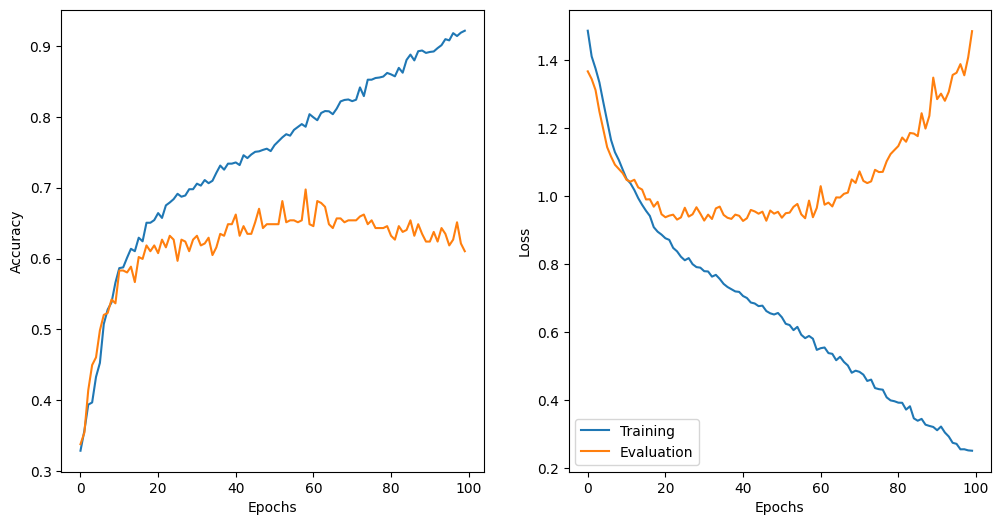

In [9]:
from utils.plot_result import plot_result

plot_result(num_epochs,
            train_accs=metrics['train_accuracy'],
            eval_accs=metrics['valid_accuracy'],
            train_losses=metrics['train_loss'],
            eval_losses=metrics['valid_loss'])

#### Fine tuning

In [12]:
!pip install -q -U transformers accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


##### Modeling

In [13]:
from transformers import ViTForImageClassification

id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id, label in id2label.items()}

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=num_classes,
                                                  id2label=id2label,
                                                  label2id=label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [19]:
import evaluate
import numpy as np

metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [20]:
import torch
from transformers import ViTImageProcessor
from transformers import TrainingArguments, Trainer

feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

metric_name = 'accuracy'

args = TrainingArguments(
    f'vit_flowers',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False
)

def collate_fn(examples):
    # example => Tuple(image, label)
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {'pixel_values': pixel_values, 'labels': labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_datset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-f573e29a9ec2>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
import wandb
wandb.init(mode='disabled')

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.281902,0.950954
2,No log,0.174102,0.978202
3,No log,0.157170,0.964578
4,No log,0.144936,0.967302
5,No log,0.138901,0.961853
6,0.148400,0.138262,0.964578
7,0.148400,0.134042,0.961853
8,0.148400,0.134342,0.961853
9,0.148400,0.133572,0.961853
10,0.148400,0.134163,0.961853


TrainOutput(global_step=920, training_loss=0.1034159287162449, metrics={'train_runtime': 1184.1785, 'train_samples_per_second': 24.794, 'train_steps_per_second': 0.777, 'total_flos': 2.2752259898322125e+18, 'train_loss': 0.1034159287162449, 'epoch': 10.0})

In [23]:
output = trainer.predict(test_dataset)
output.metrics

{'test_loss': 0.11701838672161102,
 'test_accuracy': 0.9727520435967303,
 'test_runtime': 5.9271,
 'test_samples_per_second': 61.919,
 'test_steps_per_second': 2.025}